**Цель задания:**

Научиться использовать в коде различные методы Transfer Learning на примере датасета персонажей мультфильма Симпсонов

In [ ]:
import torchvision as tv
from torchvision import transforms
import torch
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import pandas as pd
import glob
from collections import defaultdict
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch_directml
device = torch_directml.device()

In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
data_dir = "simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")

In [ ]:
data_image_labels = [path.split("\\")[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 14653
Изображений в val: 6280


In [ ]:
input_size = 128

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file= lambda x: x in train_files_path
)

val_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file= lambda x: x in val_files_path
)

In [ ]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


In [ ]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

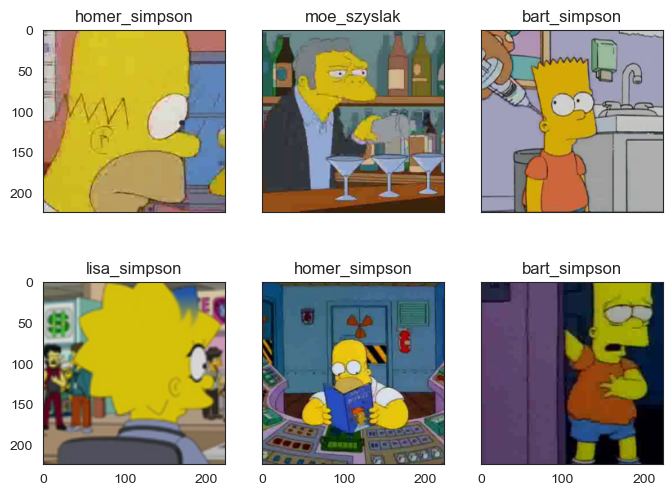

In [ ]:
show_images(val_dataset)

# 1) Модифицируйте код обучения, используя различные типы LR Schedulers из Pytorch. Проведите минимум 2 эксперимента с разными шедулерами.

**Для обучения будем использовать архитектуру модели ResNet18**

Архитектура ResNet-18 (Residual Network-18) является сверточной нейронной сетью, разработанной для решения проблемы затухающего градиента в глубоких сетях. Она состоит из блоков с остаточными (residual) соединениями, которые позволяют эффективно обучать глубокие модели.

Принцип работы и архитектура ResNet-18 следующие:

1. **Входные данные:** Входом в ResNet-18 являются изображения размером 224x224 пикселя (обычно цветные изображения с тремя каналами: красным, зеленым и синим).

2. **Сверточные и пулинговые слои:** Сеть начинается с одного сверточного слоя с ядром 7x7 и шагом 2, за которым следует пулинговый слой с ядром 3x3 и шагом 2. Это позволяет уменьшить размерность изображения и извлечь некоторые низкоуровневые признаки.

3. **Блоки с остаточными соединениями:** Основной компонент ResNet-18 - это остаточные блоки. Каждый остаточный блок состоит из нескольких слоев свертки, нормализации и активации. Однако здесь используется концепция остаточных соединений (skip connections). Вместо того чтобы полагаться только на вывод текущего слоя, блок также добавляет остаток (разницу) между входом и выходом слоя. Это означает, что выход блока - это сумма остатка и выхода текущего слоя. Это позволяет градиентам "пропрыгивать" через слои, что упрощает обучение глубоких моделей.

4. **Количество блоков:** Архитектура ResNet-18 состоит из 18 слоев свертки, включая остаточные блоки. Эти блоки группируются по два, четыре, четыре и два в блоки ResNet-18.

5. **Глобальное усреднение и классификация:** После последнего остаточного блока используется глобальное усреднение (Global Average Pooling), чтобы преобразовать карту признаков в одномерный вектор. Затем следует полносвязный слой для классификации. Количество выходных нейронов в этом слое соответствует количеству классов в задаче классификации. Для задачи бинарной классификации или многоклассовой классификации используется функция Softmax для получения вероятностей принадлежности к классам.

Принцип работы ResNet-18 заключается в использовании остаточных соединений для облегчения обучения глубоких сетей и предотвращения затухания градиентов. Это позволяет создавать более глубокие и более производительные модели для различных задач компьютерного зрения, таких как классификация изображений, сегментация объектов и многие другие.


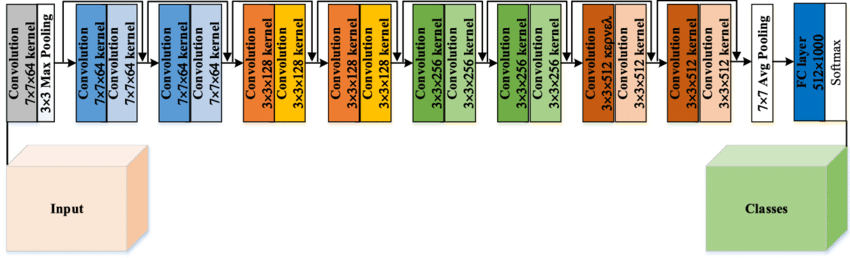

In [ ]:
from torchvision.models import resnet18

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    scheduler,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)


        scheduler.step()

        torch.cuda.empty_cache()

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)


        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
batch_size = 32

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

## MultiStepLR

MultiStepLR - это стратегия изменения темпа (learning rate) в процессе обучения нейронной сети в рамках методов оптимизации глубокого обучения. Она является одной из стратегий изменения темпа обучения, которые используются для улучшения сходимости и качества обучения нейронных сетей.

Суть MultiStepLR заключается в следующем: в течение обучения модели, в предварительно определенные моменты времени (эпохи) происходит изменение темпа обучения. Обычно это происходит путем уменьшения темпа на определенный коэффициент, который задается пользователем. Это позволяет модели "замедляться" в процессе обучения и более точно приближаться к оптимальным значениям параметров.

Преимущества MultiStepLR:

1. **Улучшение стабильности обучения**: Поскольку в начале обучения модель может двигаться слишком быстро и "перескакивать" через оптимум, уменьшение темпа обучения с течением времени помогает стабилизировать процесс.

2. **Более точная сходимость**: Медленное уменьшение темпа обучения позволяет модели более точно приближаться к минимуму функции потерь.

3. **Уменьшение переобучения**: Метод MultiStepLR может помочь уменьшить вероятность переобучения, так как он позволяет "затормаживать" обучение ближе к концу процесса.


In [ ]:
from torch.optim.lr_scheduler import MultiStepLR

In [ ]:
model = resnet18(pretrained=False)

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.classifier = nn.Linear(512, 42)

In [ ]:
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.1)

Epoch 10 of 10 took 535.369s
  training loss (in-iteration): 	0.884100
  validation loss (in-iteration): 	0.914922
  training accuracy: 			75.53 %
  validation accuracy: 			74.90 %


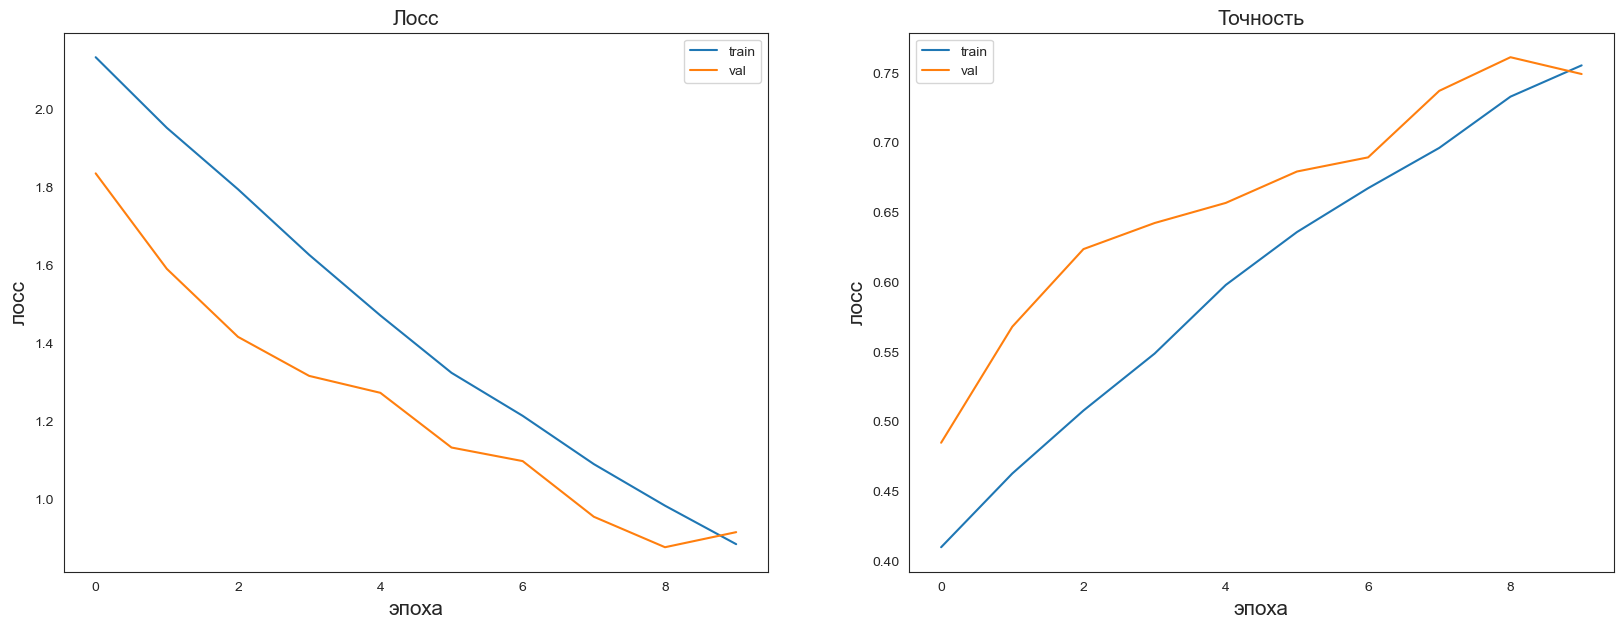

In [ ]:
clf_model_MultiStepLR, history_MultiStepLR = train(
    model, criterion, optimizer, scheduler,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

## Cyclic Learning Rate

CyclicLR (Cyclic Learning Rate) - это стратегия автоматического управления темпом обучения (learning rate) в процессе обучения нейронной сети путем периодического изменения темпа обучения между верхней и нижней границей. Эта стратегия позволяет создавать циклические колебания темпа обучения в течение нескольких эпох, что может помочь улучшить сходимость модели, предотвратить застревание в локальных минимумах и расширить пространство поиска оптимальных параметров.

Принцип работы CyclicLR заключается в следующем:

1. **Установка верхней и нижней границ**: Пользователь определяет верхнюю (`base_lr`) и нижнюю (`max_lr`) границы для темпа обучения. В течение каждого цикла обучения, темп обучения будет изменяться между этими границами.

2. **Функция колебания**: CyclicLR может использовать различные функции для изменения темпа обучения внутри цикла. Например, можно использовать треугольное или треугольное экспоненциальное колебание.

3. **Циклические колебания**: В процессе обучения темп обучения будет меняться циклически между верхней и нижней границей с заданным шагом.

Преимущества CyclicLR:

1. **Расширение пространства поиска**: Циклические колебания темпа обучения позволяют модели исследовать более широкий диапазон оптимальных параметров и избежать застревания в локальных минимумах.

2. **Предотвращение переобучения**: Циклические колебания могут помочь предотвратить переобучение, так как темп обучения периодически увеличивается, что может помочь модели "выбраться" из локальных минимумов.

3. **Симплексная реализация**: CyclicLR обычно реализуется сравнительно просто, и он может быть легко внедрен в процесс обучения.



In [ ]:
from torch.optim.lr_scheduler import CyclicLR

In [ ]:
model2 = resnet18(pretrained=False)

In [ ]:
model2.classifier = nn.Linear(512, 42)

In [ ]:
model2 = model2.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.01)
scheduler_CyclicLR = CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=2000, mode='triangular2')

Epoch 10 of 10 took 549.425s
  training loss (in-iteration): 	1.189264
  validation loss (in-iteration): 	0.987038
  training accuracy: 			66.92 %
  validation accuracy: 			72.94 %


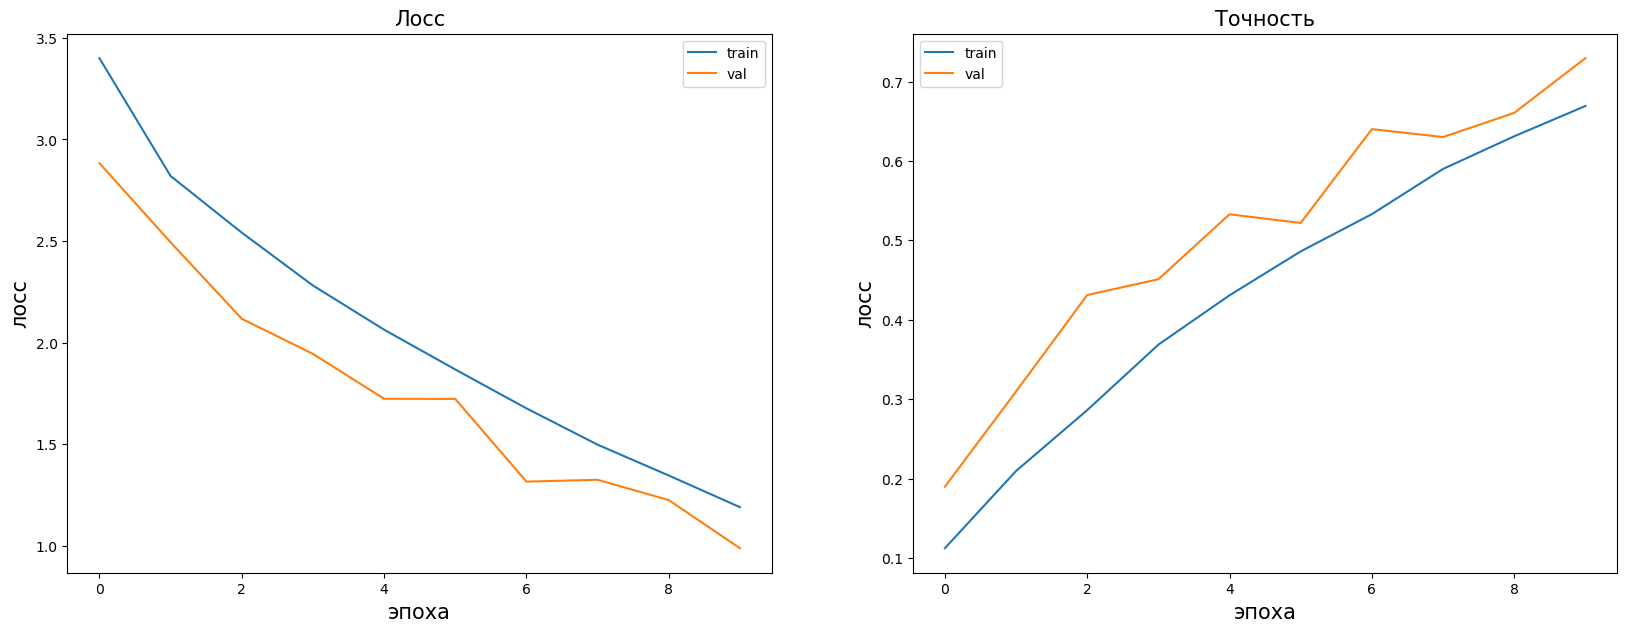

In [ ]:
clf_model2, history2 = train(
    model2, criterion, optimizer, scheduler_CyclicLR,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

# 2) Подберите аугментации train данных, при которых итоговое качество на валидации станет сильно хуже, чем полученное на занятии.

**RandomAffine** - это трансформация аугментации в библиотеке torchvision для изменения геометрии изображения путем применения аффинных преобразований с случайными параметрами. Аффинные преобразования включают в себя поворот, сдвиг, масштабирование и отражение изображения.

**ColorJitter** - это трансформация для изменения цветовых характеристик изображения. Эта трансформация позволяет случайным образом изменять яркость, контраст, насыщенность и оттенок изображения.

**RandomHorizontalFlip** - это трансформация для случайного горизонтального отражения изображения.

**GaussianBlur** представляет собой размытие изображения с использованием гауссовского фильтра. Это может добавить размытие и сглаживание к изображению, что может сделать задачу классификации или детекции более сложной и помочь модели более эффективно обобщать.

**ElasticTransform**- это метод аугментации, который вносит случайные искажения в изображение, имитируя эффект эластичной деформации. Это может помочь модели стать устойчивее к деформациям и искажениям в данных.

In [ ]:
# Собственная трансформация для добавления шума
class RandomNoise(object):
    def __init__(self, noise_level=0,):
        self.noise_level = noise_level

    def __call__(self, image):
        image_tensor = transforms.ToTensor()(image)
        noise = torch.randn_like(image_tensor)
        noisy_image = image_tensor + noise * self.noise_level
        noisy_image = torch.clamp(noisy_image, 0, 1)
        noisy_image_pil = transforms.ToPILImage()(noisy_image)

        return noisy_image_pil

In [ ]:
input_size = 32

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ElasticTransform(alpha= 80., sigma= 5.),
    transforms.RandomHorizontalFlip(),
    RandomNoise(noise_level=0.1),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file= lambda x: x in train_files_path
)

val_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file= lambda x: x in val_files_path
)

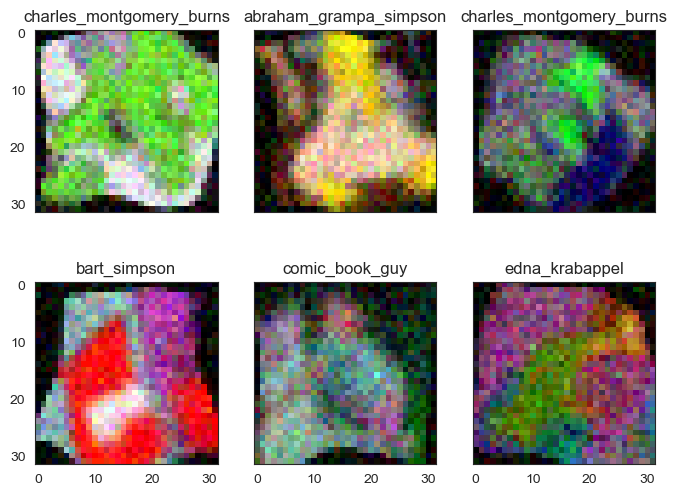

In [ ]:
show_images(train_dataset)

In [ ]:
batch_size = 32

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [ ]:
model_bad_aug = resnet18(pretrained=False)

In [ ]:
model_bad_aug.classifier = nn.Linear(512, 42)

In [ ]:
model_bad_aug = model_bad_aug.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_bad_aug.parameters(), lr=0.01)
scheduler_CyclicLR = CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=2000, mode='triangular2')

Epoch 10 of 10 took 398.100s
  training loss (in-iteration): 	2.001452
  validation loss (in-iteration): 	1.537355
  training accuracy: 			43.68 %
  validation accuracy: 			56.66 %


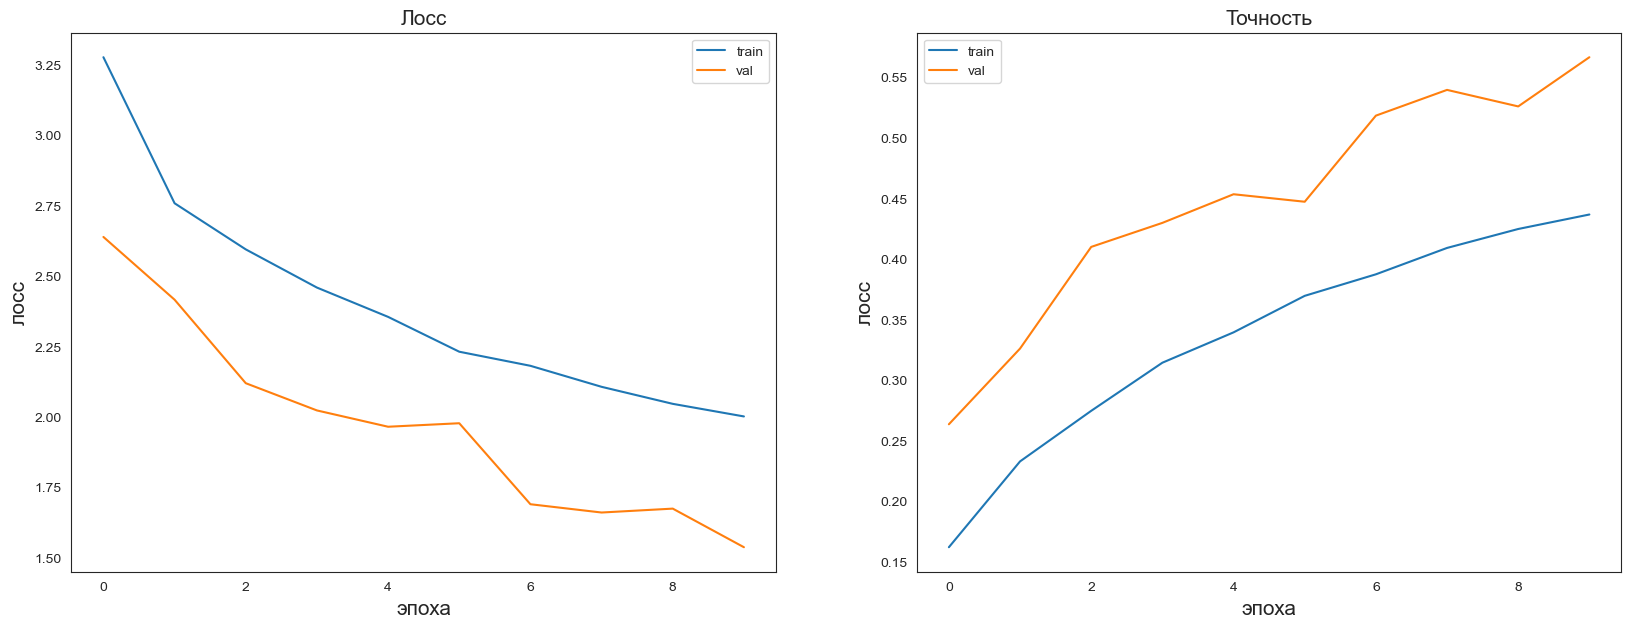

In [ ]:
clf_model_bad_aug, history_model_bad_aug = train(
    model_bad_aug, criterion, optimizer, scheduler_CyclicLR,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

# 3) Возьмите любую архитектуру (VGG, EfficientNet или MobileNet) и примените к ней методы, которые разбирались на занятии.

In [ ]:
from torchvision.models import mobilenet_v3_small

**Будем использовать архитектуру MobileNet**

Архитектура MobileNetV3_small представляет собой легкую нейронную сеть, оптимизированную для работы на мобильных и встроенных устройствах с ограниченными ресурсами. Она основана на принципе Depthwise Separable Convolution и включает в себя инновационные операции, которые обеспечивают хороший баланс между вычислительной эффективностью и качеством предсказаний.

Принцип работы и особенности архитектуры MobileNetV3_small:

1. **Depthwise Separable Convolution:** Это ключевая операция, которая разделяет стандартную свертку на две части: глубинную свертку (depthwise convolution) и свертку через точку (pointwise convolution).

   - **Глубинная свертка (Depthwise Convolution):** В этой операции каждый входной канал обрабатывается отдельно с помощью своего ядра свертки. Это позволяет значительно снизить количество вычислений.

   - **Свертка через точку (Pointwise Convolution):** После глубинной свертки применяется 1x1 свертка (свертка через точку), чтобы объединить результаты глубинной свертки и создать новые комбинации признаков.

2. **Бутстрап-каналы (Bootstrap Channels):** MobileNetV3 включает инвертированные остаточные бутстрап-каналы, которые позволяют модели более эффективно извлекать информацию из данных. Эти блоки обогащают представление признаков.

3. **OEM-Activation:** Операция активации, известная как "oem-activation" (меньше обычных экспоненциальных линейных единиц), используется для достижения баланса между активацией и сохранением градиента вблизи нуля.

4. **Global Average Pooling:** В конце сети используется глобальное усреднение, чтобы преобразовать карту признаков в одномерный вектор.

5. **Efficient Last Bottleneck:** В завершающем усеченном бутстрап-канале используется оптимизированный подход для поддержания качества предсказания при снижении вычислительной нагрузки.

Преимущества использования архитектуры MobileNetV3_small:

- **Эффективность:** Архитектура оптимизирована для мобильных и встроенных устройств, что обеспечивает хорошую производительность при ограниченных ресурсах.

- **Компактность:** Модель имеет низкое количество параметров, что позволяет использовать ее на устройствах с ограниченным объемом памяти.

- **Хорошее качество предсказаний:** Несмотря на легкость и эффективность, MobileNetV3_small способен достичь приемлемого качества на различных задачах компьютерного зрения.

Архитектура MobileNetV3_small - это пример того, как инновации в операциях свертки и активации могут помочь создать легкие и эффективные нейронные сети, адаптированные к работе на устройствах с ограниченными ресурсами.


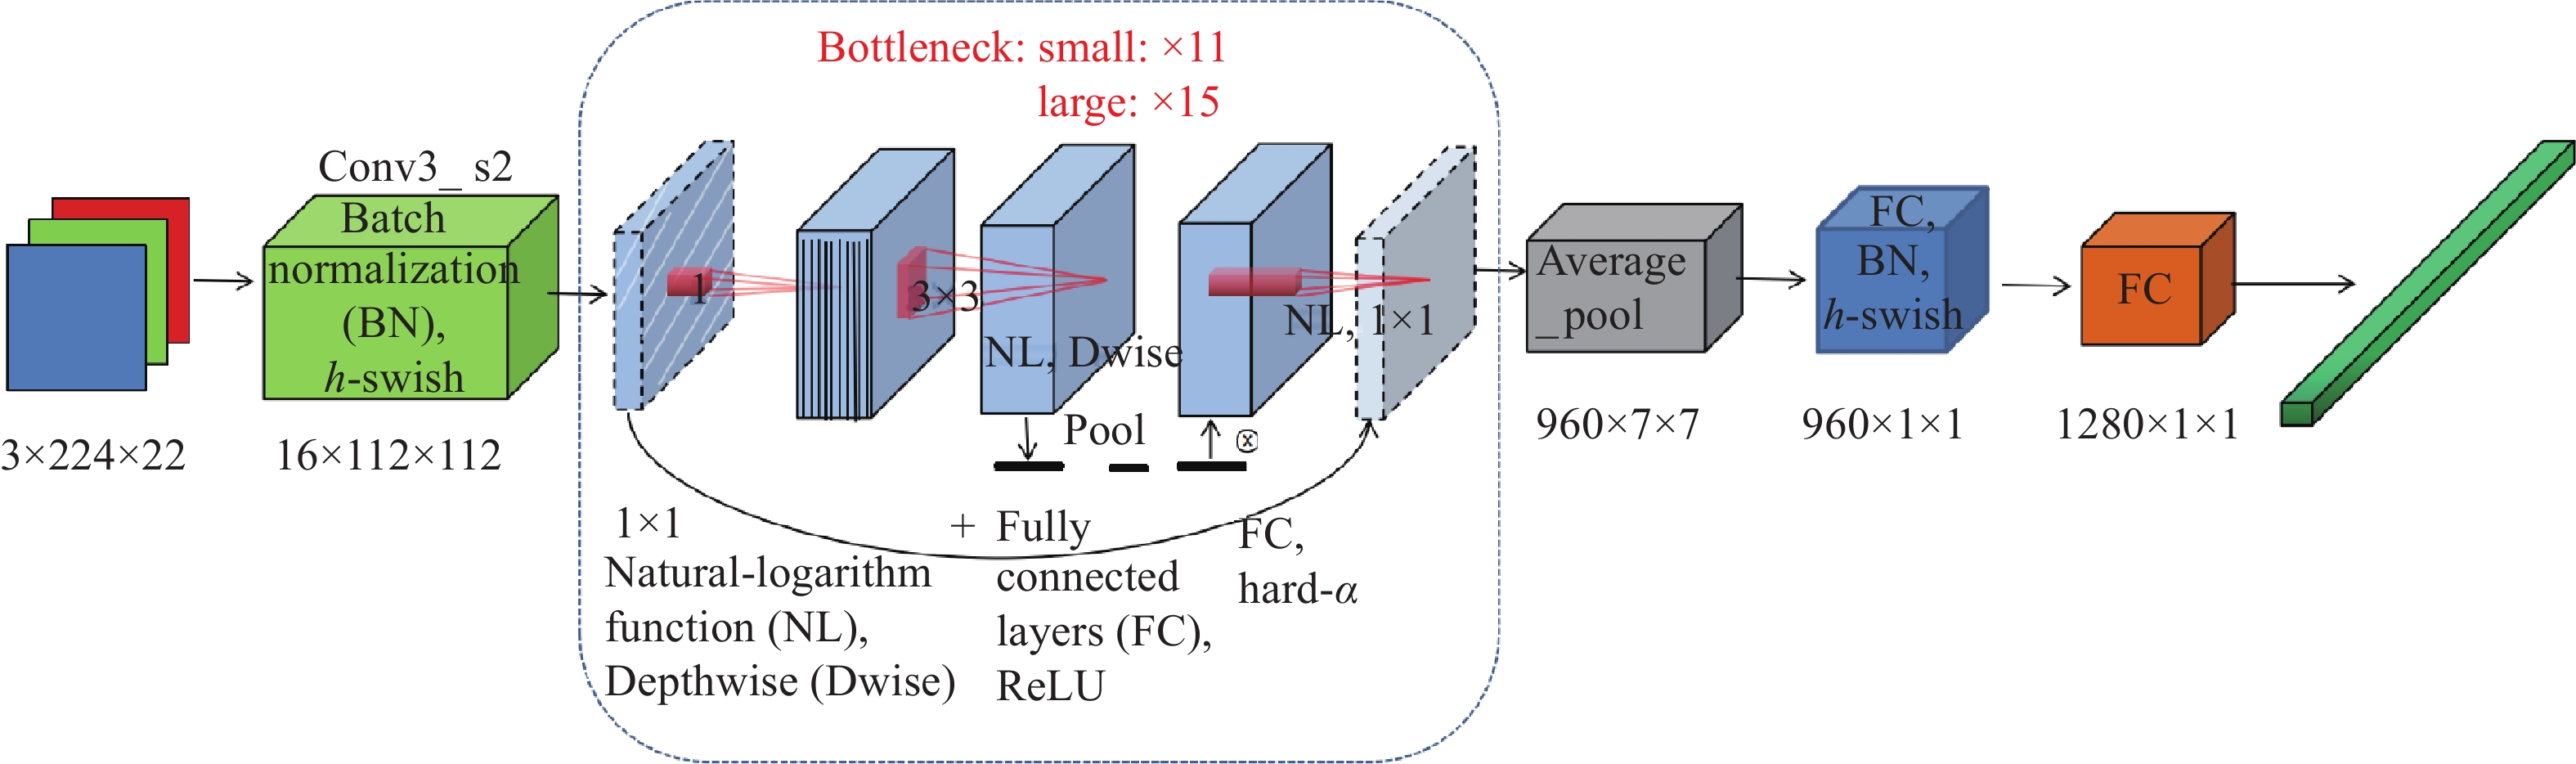

## Feature Extractor

In [ ]:
model_FE = mobilenet_v3_small(pretrained=True)

In [ ]:
model_FE

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
# заморозим все слои сети
for param in model_FE.parameters():
    param.requires_grad = False

In [ ]:
# добавим над feature extractor сетью классификационный слой
model_FE.classifier[3] = nn.Linear(1024, 42)

In [ ]:
model_FE = model_FE.to(device)

In [ ]:
def train_FE_FT(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
input_size = 128

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file= lambda x: x in train_files_path
)

val_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file= lambda x: x in val_files_path
)

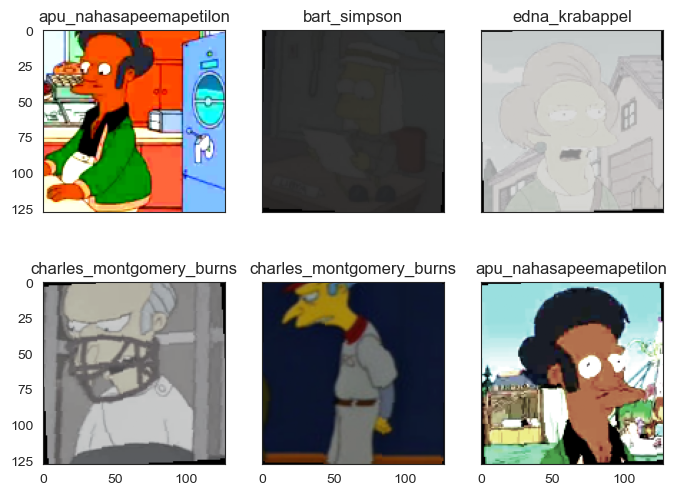

In [ ]:
show_images(train_dataset)

In [ ]:
batch_size = 32

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_FE.parameters(), lr=0.01)

Epoch 10 of 10 took 338.906s
  training loss (in-iteration): 	3.766106
  validation loss (in-iteration): 	3.011644
  training accuracy: 			38.59 %
  validation accuracy: 			54.44 %


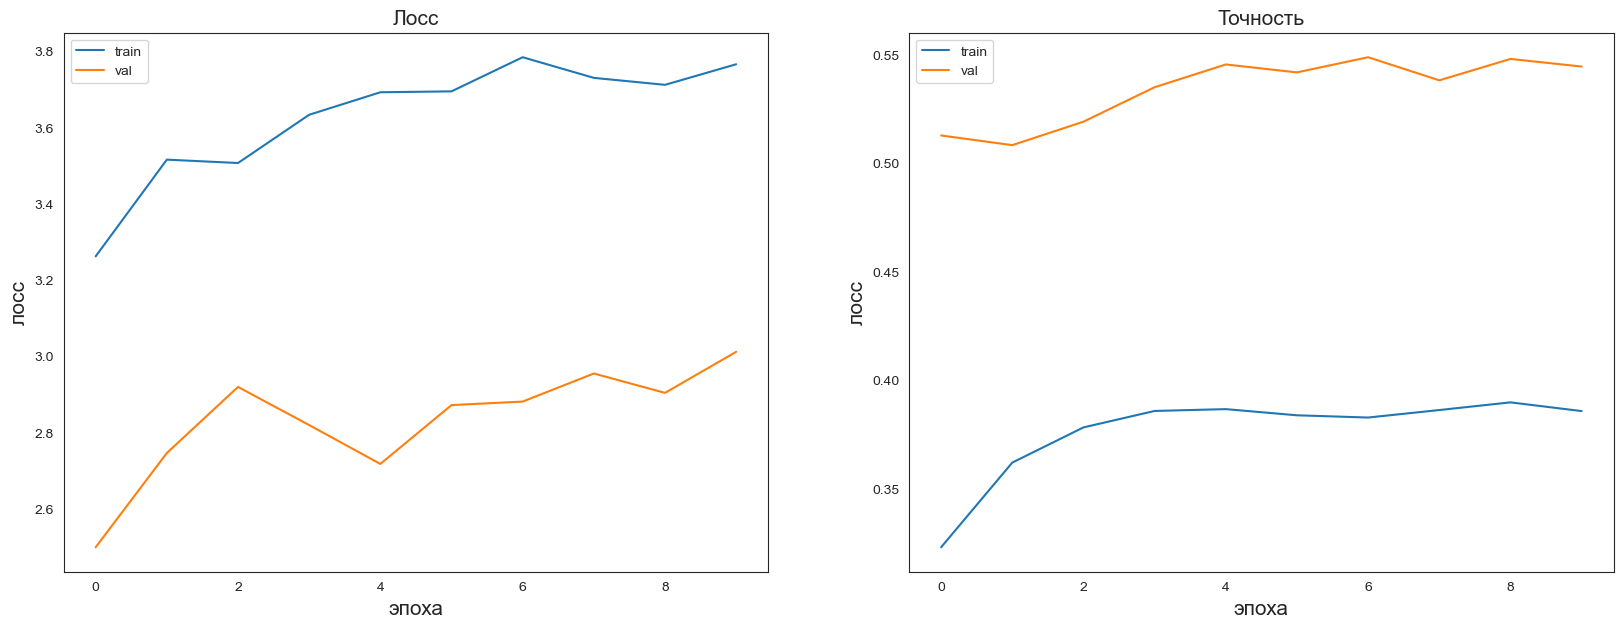

In [ ]:
FE_model_clf, history = train_FE_FT(
    model_FE, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

##FineTuning

In [ ]:
model_FT = nn.Sequential()

In [ ]:
mobilenet_v3 = mobilenet_v3_small(pretrained=True)

In [ ]:
for param in mobilenet_v3.parameters():
    param.requires_grad = False

In [ ]:
model_FT.add_module('mobilnet3', mobilenet_v3)

In [ ]:
# добавим новые слои для классификации для нашей конкретной задачи
model_FT.add_module('relu_1', nn.ReLU())
model_FT.add_module('fc_1', nn.Linear(1000, 256))
model_FT.add_module('relu_2', nn.ReLU())
model_FT.add_module('fc_2', nn.Linear(256, 42))

model_FT = model_FT.to(device)

In [ ]:
model_FT

Sequential(
  (mobilnet3): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Con

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_FT.parameters(), lr=0.01)

Epoch 10 of 10 took 354.102s
  training loss (in-iteration): 	2.750885
  validation loss (in-iteration): 	2.521964
  training accuracy: 			26.38 %
  validation accuracy: 			33.91 %


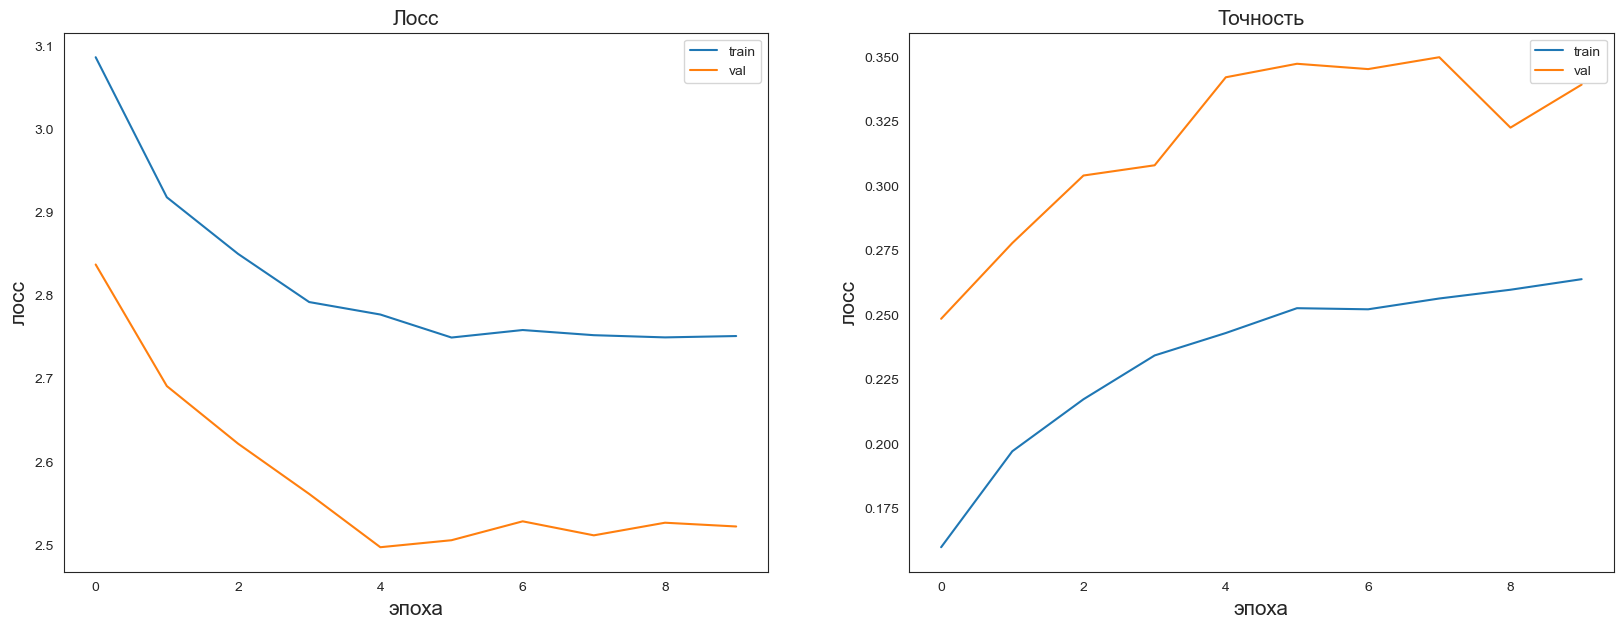

In [ ]:
FT_model_clf, history = train_FE_FT(
    model_FT, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

# Вывод

Эксперименты с LR Schedulers, аугментациями и обучением различных сетей позволили лучше понять влияние этих факторов на производительность моделей. Правильный выбор параметров и методов обучения является ключевым фактором для достижения высокой точности. Каждый параметр и метод играют роль в балансе между стабильностью обучения и адаптацией к разнообразным данным